In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

# Teleportation
https://qiskit.org/textbook/ch-algorithms/teleportation.html

<IPython.core.display.Math object>

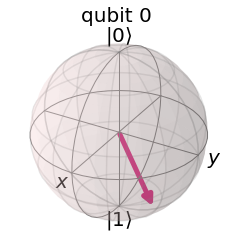

In [20]:
psi = random_state(1)
array_to_latex(psi, pretext="|\\psi\\rangle =")
plot_bloch_multivector(psi)